In [1]:
import os
os.environ["PATH"] = "/usr/local/cuda-11.8/bin:{}".format(os.environ["PATH"])
os.environ["LD_LIBRARY_PATH"] = "/usr/local/cuda-11.8/lib64"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import sys
sys.path.append("/home/yang_liu/python_workspace/gaussian-splatting-lightning")

import yaml
import torch
import numpy as np
import random

from internal.utils.ssim import ssim
from matplotlib import pyplot as plt
from internal.utils.general_utils import parse
from internal.utils.gaussian_model_loader import GaussianModelLoader
from internal.dataparsers.colmap_dataparser import ColmapParams, ColmapDataParser
from internal.utils.blocking import contract_to_unisphere
from internal.utils.mesh_utils import focus_point_fn
from internal.dataparsers.colmap_block_dataparser import ColmapBlockDataParser
from internal.dataparsers.estimated_depth_colmap_block_dataparser import EstimatedDepthColmapDataParser
from internal.renderers.vanilla_renderer import VanillaRenderer
from internal.renderers.vanilla_trim_renderer import VanillaTrimRenderer
from internal.utils.sh_utils import eval_gaussian_model_sh

torch.set_grad_enabled(False)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# load model and dataset
config_path = "../configs/citygs2d_lfls_lnorm4_wo_vast_sep_depth.yaml"
with open(config_path, 'r') as f:
    config = parse(yaml.load(f, Loader=yaml.FullLoader))

    ckpt_path = os.path.join('..', config.model.init_from)
    if 'point_cloud' in config.model.init_from:
        model_path = config.model.init_from.split("/point_cloud/")[0]
    elif 'checkpoints' in config.model.init_from:
        model_path = config.model.init_from.split("/checkpoints/")[0]
    
    if config.data.type == "estimated_depth_colmap_block":
        params = config.data.params.estimated_depth_colmap_block
    else:
        params = config.data.params.colmap_block
block_dim = params.block_dim
aabb = params.aabb
num_threshold = params.num_threshold
content_threshold = params.content_threshold

In [3]:
model, renderer, _ = GaussianModelLoader.initialize_simplified_model_from_checkpoint(ckpt_path, device="cuda")
print("Gaussian count: {}".format(model.get_xyz.shape[0]))

config_path = os.path.join('..', model_path, "config.yaml")
with open(config_path, 'r') as f:
    config = parse(yaml.load(f, Loader=yaml.FullLoader))

# TODO: support other data parser
if config.data.type == "estimated_depth_colmap_block":
    dataparser_outputs = EstimatedDepthColmapDataParser(
        os.path.expanduser(os.path.join('..', config.data.path)),
        os.path.abspath(""),
        global_rank=0,
        params=config.data.params.estimated_depth_colmap_block,
    ).get_outputs()
else:
    dataparser_outputs = ColmapBlockDataParser(
        os.path.expanduser(os.path.join('..', config.data.path)),
        os.path.abspath(""),
        global_rank=0,
        params=config.data.params.colmap_block,
    ).get_outputs()

Gaussian count: 7081975
appearance group by camera id
loading colmap 3D points
down sample enabled
[colmap dataparser] train set images: 958, val set images: 120, loaded mask: 0
[WARNING depth scale of DJI_20240315152247_0017_Zenmuse-L1-mission.JPG out of bound]
[WARNING depth scale of DJI_20240315152249_0018_Zenmuse-L1-mission.JPG out of bound]
[WARNING depth scale of DJI_20240307170015_0199_Zenmuse-L1-mission.JPG out of bound]
[WARNING depth scale of DJI_20240315152607_0051_Zenmuse-L1-mission.JPG out of bound]
found 1074 depth maps


In [4]:
xyz_org = model.get_xyz
dataset = dataparser_outputs.train_set
block_num = block_dim[0] * block_dim[1] * block_dim[2]
bg_color=torch.tensor(config.model.background_color, dtype=torch.float, device="cuda")
if aabb is None:
    torch.cuda.empty_cache()
    c2ws = np.array([np.linalg.inv(np.asarray((cam.world_to_camera.T).cpu().numpy())) for cam in dataset.cameras])
    poses = c2ws[:,:3,:] @ np.diag([1, -1, -1, 1])
    center = (focus_point_fn(poses))
    radius = torch.tensor(np.median(np.abs(c2ws[:,:3,3] - center), axis=0), device=xyz_org.device)
    center = torch.from_numpy(center).float().to(xyz_org.device)
    if radius.min() / radius.max() < 0.02:
        # If the radius is too small, we don't contract in this dimension
        radius[torch.argmin(radius)] = 0.5 * (xyz_org[:, torch.argmin(radius)].max() - xyz_org[:, torch.argmin(radius)].min())
    aabb = torch.zeros(6, device=xyz_org.device)
    aabb[:3] = center - radius
    aabb[3:] = center + radius
xyz = contract_to_unisphere(xyz_org, aabb, ord=torch.inf)
print("aabb: ", aabb)

aabb:  tensor([-1.9060, -0.6012, -0.6328,  1.8726,  1.9804,  2.0541], device='cuda:0')


In [5]:
block_id = 2
block_id_z = block_id // (block_dim[0] * block_dim[1])
block_id_y = (block_id % (block_dim[0] * block_dim[1])) // block_dim[0]
block_id_x = (block_id % (block_dim[0] * block_dim[1])) % block_dim[0]

min_x, max_x = float(block_id_x) / block_dim[0], float(block_id_x + 1) / block_dim[0]
min_y, max_y = float(block_id_y) / block_dim[1], float(block_id_y + 1) / block_dim[1]
min_z, max_z = float(block_id_z) / block_dim[2], float(block_id_z + 1) / block_dim[2]

num_gs, org_min_x, org_max_x, org_min_y, org_max_y, org_min_z, org_max_z = 0, min_x, max_x, min_y, max_y, min_z, max_z

while num_gs < num_threshold:
    # TODO: select better threshold
    block_mask = (xyz[:, 0] >= min_x) & (xyz[:, 0] < max_x)  \
                & (xyz[:, 1] >= min_y) & (xyz[:, 1] < max_y) \
                & (xyz[:, 2] >= min_z) & (xyz[:, 2] < max_z)
    num_gs = block_mask.sum()
    min_x -= 0.01
    max_x += 0.01
    min_y -= 0.01
    max_y += 0.01
    min_z -= 0.01
    max_z += 0.01

block_output_mask = block_mask.clone()
excluded_idx = []
start_idx = 150

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 1.055002212524414e-05
Image DJI_20240307160748_0120_Zenmuse-L1-mission.JPG


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


start_idx: 175


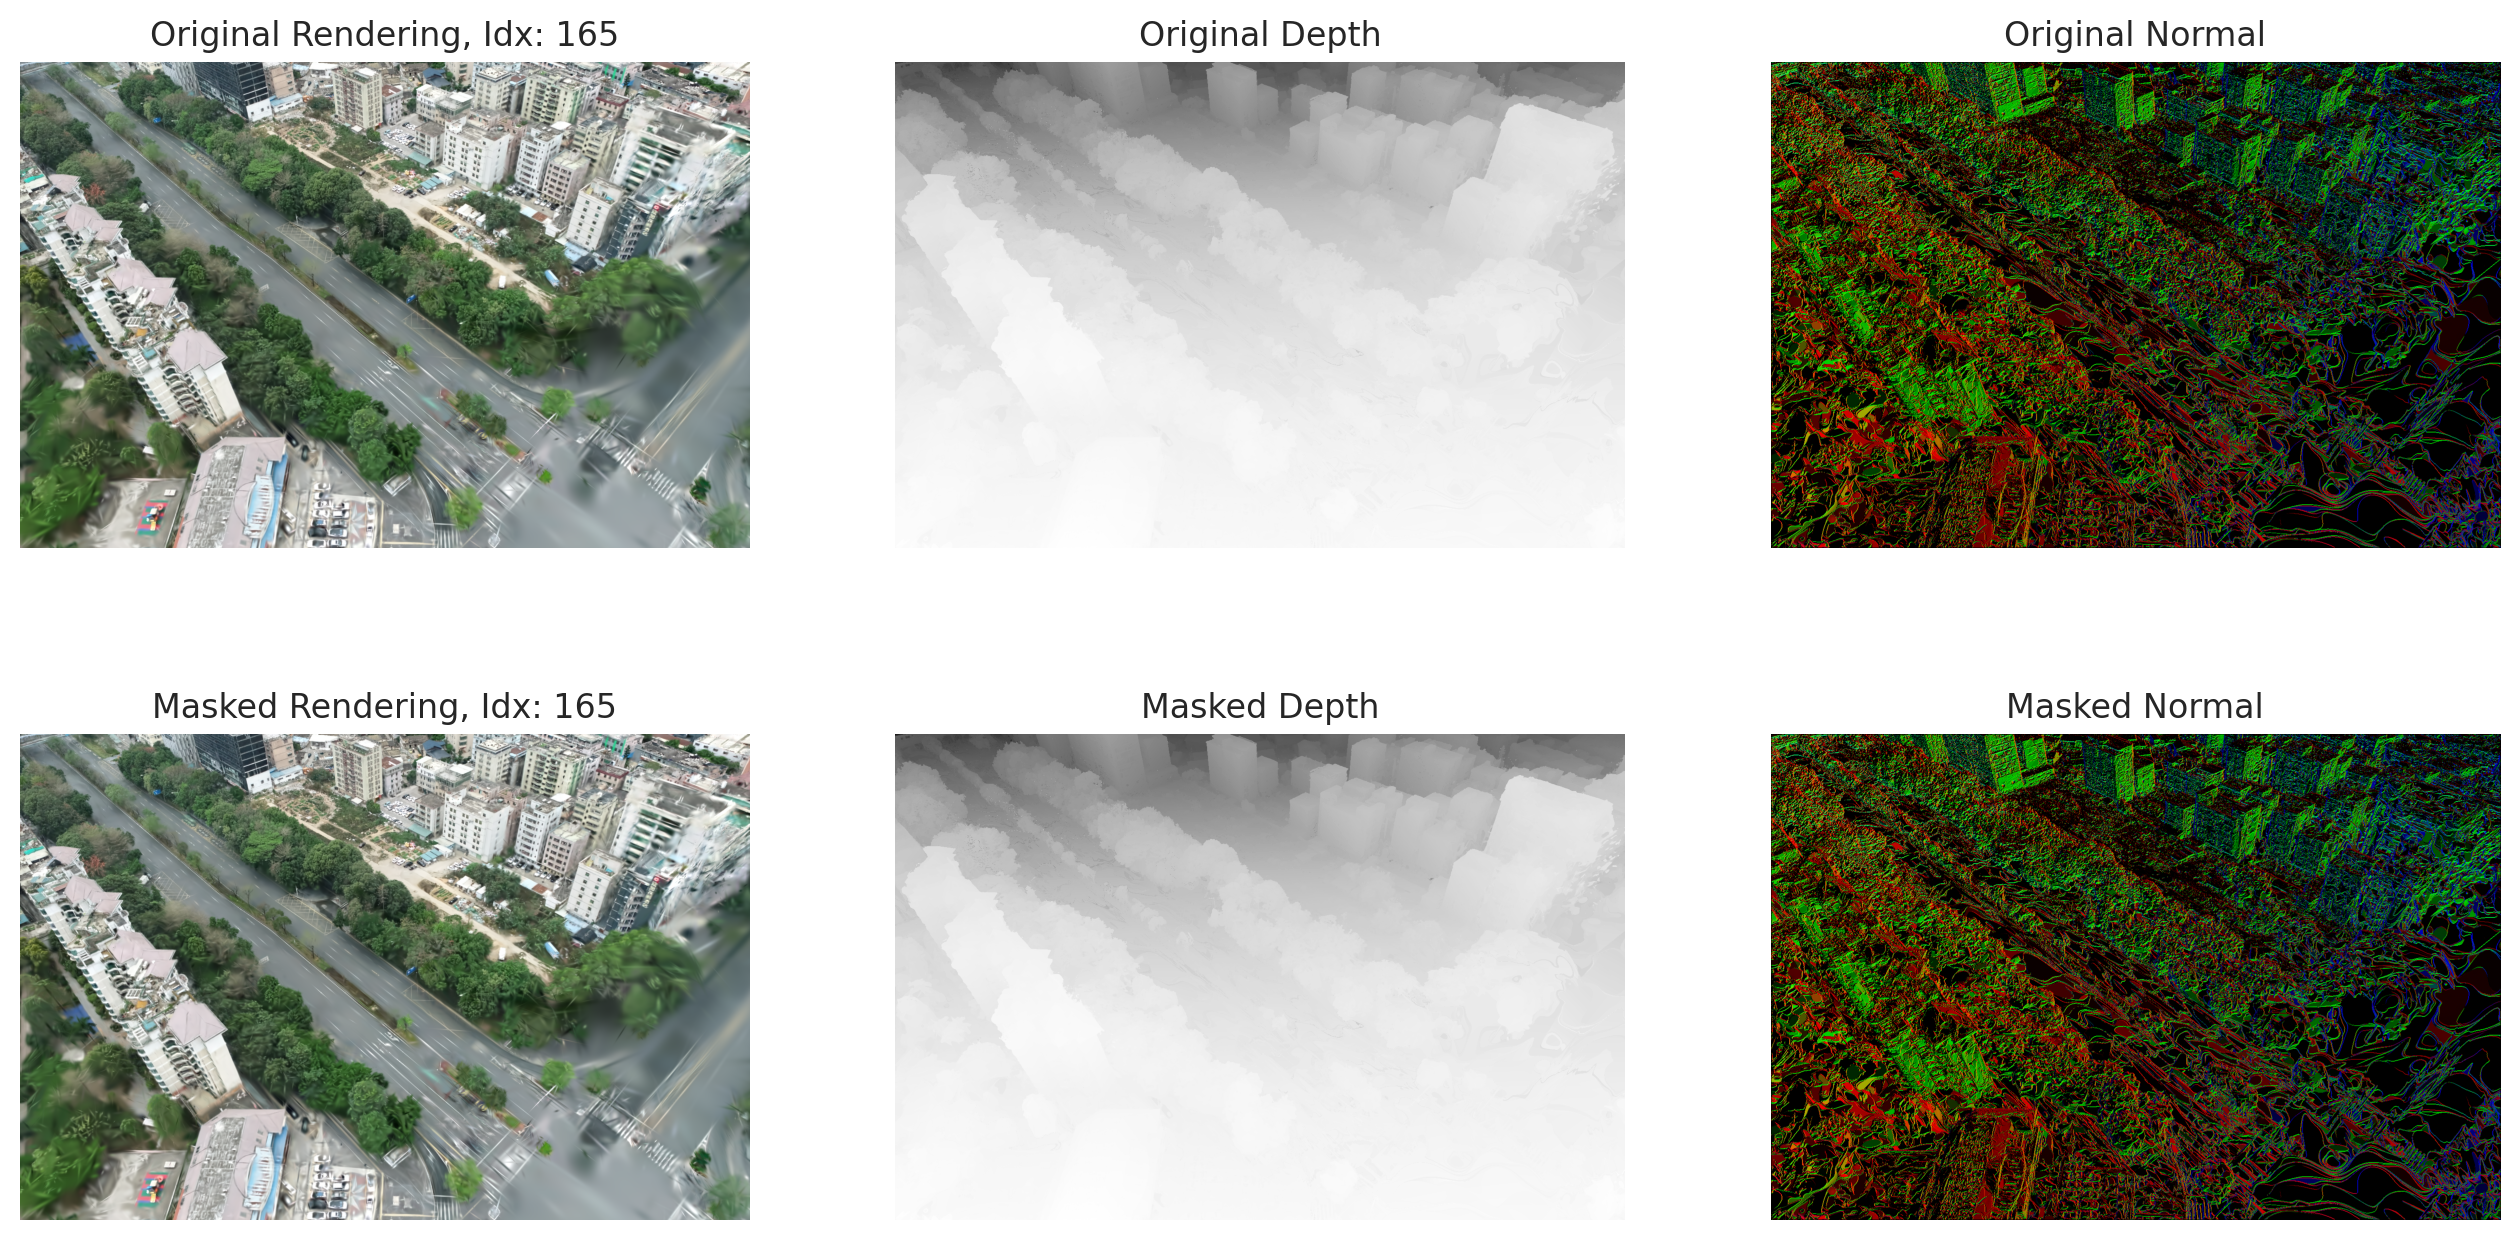

In [6]:
with torch.no_grad():
    for idx in range(start_idx, len(dataparser_outputs.train_set.cameras)):
        if idx in excluded_idx:
            continue
    
        camera = dataset.cameras[idx].to_device("cuda")
        contract_cam_center = contract_to_unisphere(camera.camera_center, aabb, ord=torch.inf)
        output = renderer(camera, model, bg_color=bg_color)

        model.select(block_mask)  # disable gaussians within block
        output_masked = renderer(camera, model, bg_color=bg_color)
        model._opacity = model._opacity_origin  # recover opacity

        loss = 1.0 - ssim(output_masked["render"], output["render"])

        if loss <= 1e-5:
            excluded_idx.append(idx)
            start_idx = idx + 1
        elif loss > 0.01:
            continue
        else:
            start_idx = idx + 10
            break

    print("Loss: {}".format(loss))
    print(f"Image {dataparser_outputs.train_set.image_names[idx]}")
    plt.style.use('seaborn-v0_8-white')
    plt.figure(figsize=(16, 8))
    plt.tight_layout()
    plt.subplot(2, 3, 1)
    plt.imshow(output["render"].permute(1, 2, 0).cpu().numpy());
    plt.title(f"Original Rendering, Idx: {idx}")
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(output["surf_depth"].permute(1, 2, 0).cpu().numpy());
    plt.title(f"Original Depth")
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(output["surf_normal"].permute(1, 2, 0).cpu().numpy());
    plt.title(f"Original Normal")
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.imshow(output_masked["render"].permute(1, 2, 0).cpu().numpy());
    plt.title(f"Masked Rendering, Idx: {idx}")
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(output_masked["surf_depth"].permute(1, 2, 0).cpu().numpy());
    plt.title(f"Masked Depth")
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(output_masked["surf_normal"].permute(1, 2, 0).cpu().numpy());
    plt.title(f"Masked Normal")
    plt.axis('off')

    print(f"start_idx: {start_idx}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image DJI_20240307163539_0261_Zenmuse-L1-mission.JPG
start_idx: 175


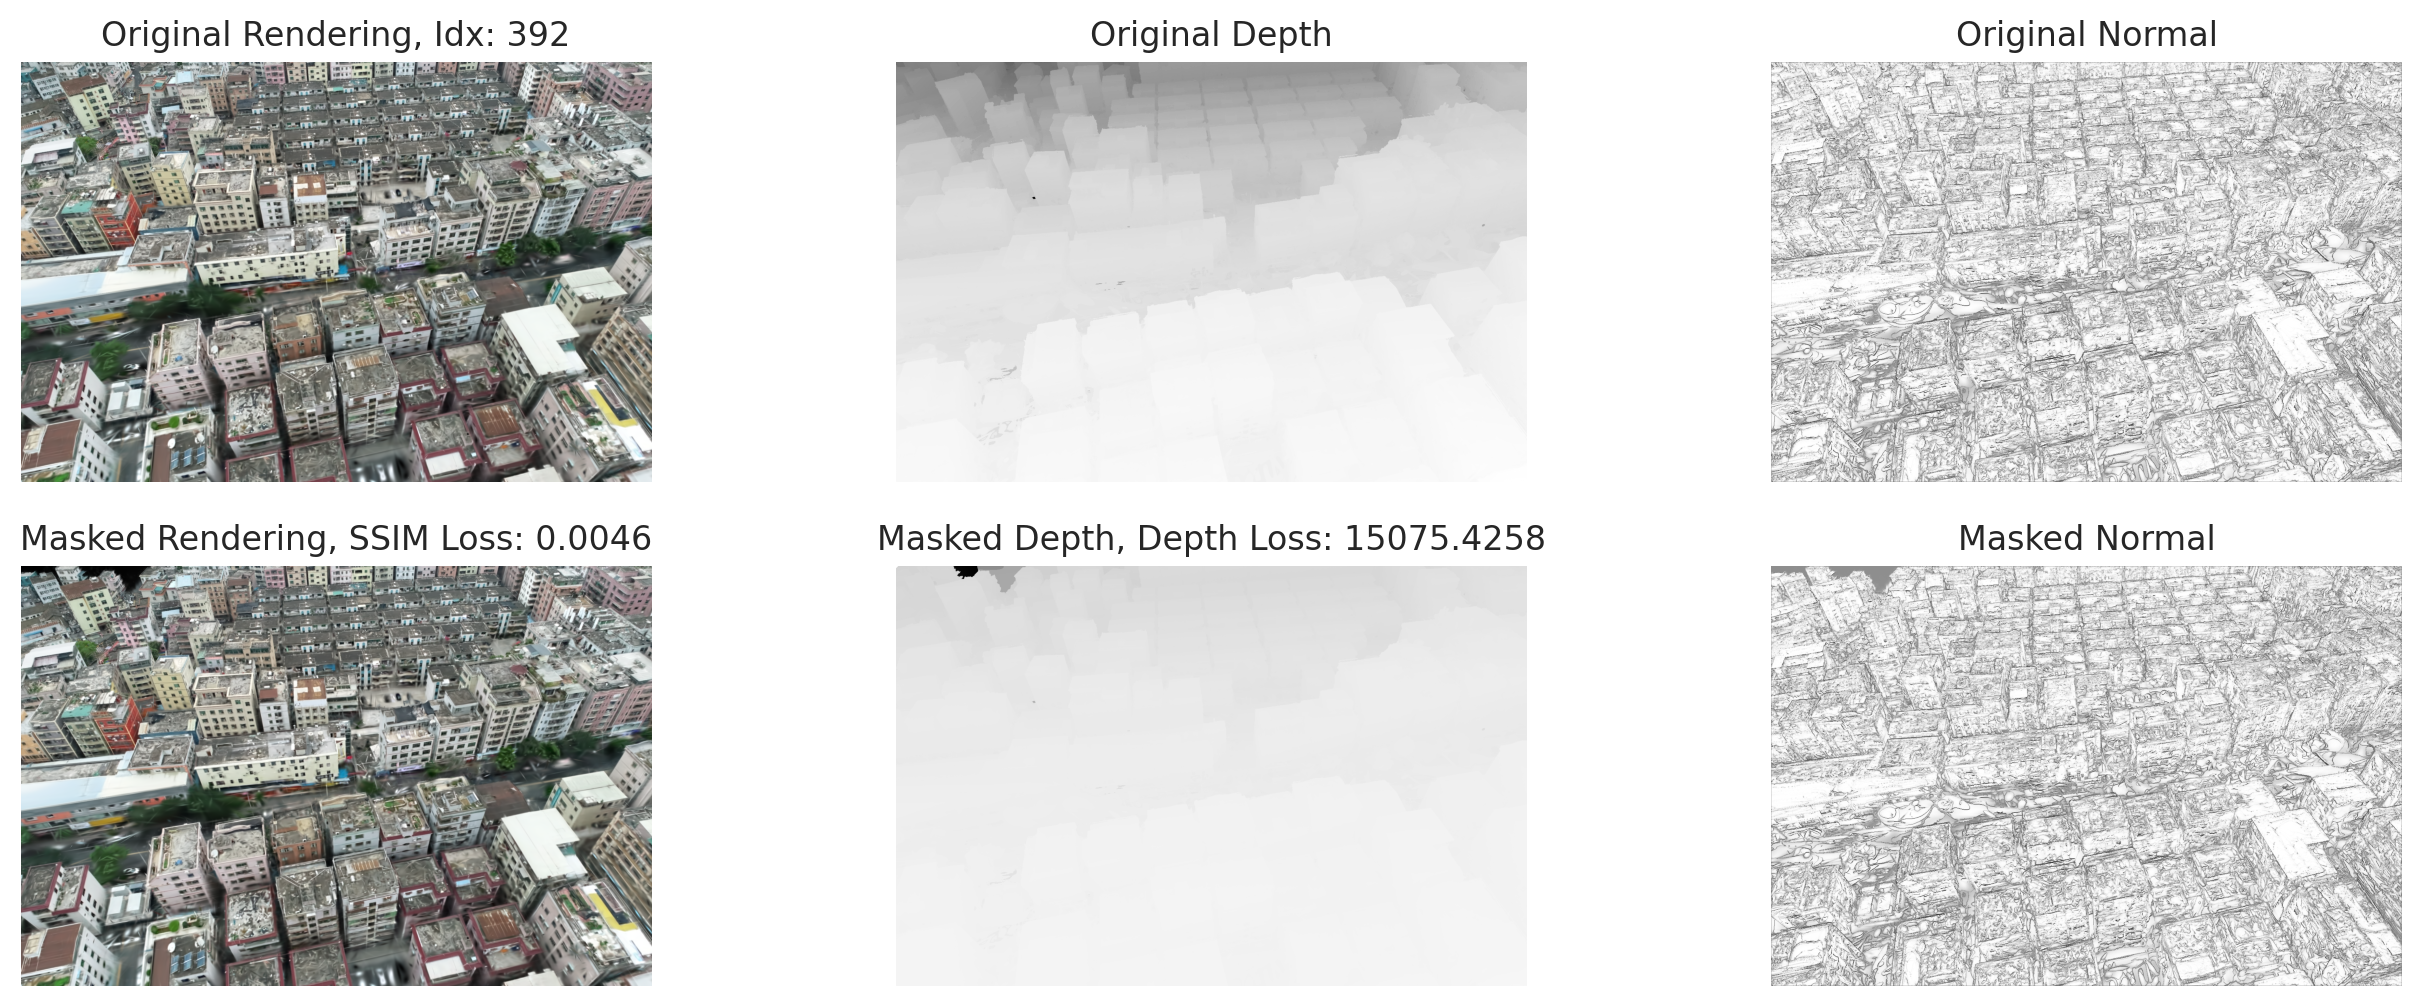

In [8]:
with torch.no_grad():

    idx = 392

    camera = dataset.cameras[idx].to_device("cuda")
    contract_cam_center = contract_to_unisphere(camera.camera_center, aabb, ord=torch.inf)
    output = renderer(camera, model, bg_color=bg_color)

    model.select(block_mask)  # disable gaussians within block
    output_masked = renderer(camera, model, bg_color=bg_color)
    model._opacity = model._opacity_origin  # recover opacity

    loss_ssim = 1.0 - ssim(output_masked["render"], output["render"])
    loss_depth = torch.abs(output_masked["surf_depth"] - output["surf_depth"]).sum()
    normal_error = (1 - (output['rend_normal'] * output['surf_normal']).sum(dim=0))[None]
    normal_error_masked = (1 - (output_masked['rend_normal'] * output_masked['surf_normal']).sum(dim=0))[None]
    
    print(f"Image {dataparser_outputs.train_set.image_names[idx]}")
    plt.style.use('seaborn-v0_8-white')
    plt.figure(figsize=(16, 6))
    plt.tight_layout()
    plt.subplot(2, 3, 1)
    plt.imshow(output["render"].permute(1, 2, 0).cpu().numpy());
    plt.title(f"Original Rendering, Idx: {idx}")
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(output["surf_depth"].permute(1, 2, 0).cpu().numpy());
    plt.title(f"Original Depth")
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(normal_error.permute(1, 2, 0).cpu().numpy());
    plt.title(f"Original Normal")
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.imshow(output_masked["render"].permute(1, 2, 0).cpu().numpy());
    plt.title(f"Masked Rendering, SSIM Loss: {loss_ssim:.4f}")
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(output_masked["surf_depth"].permute(1, 2, 0).cpu().numpy());
    plt.title(f"Masked Depth, Depth Loss: {loss_depth:.4f}")
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(normal_error_masked.permute(1, 2, 0).cpu().numpy());
    plt.title(f"Masked Normal")
    plt.axis('off')

    print(f"start_idx: {start_idx}")